# Celerite Testing
The purpose of this notebook is to begin implementing celerite to see if we can use it without significant modifications for our GP solver

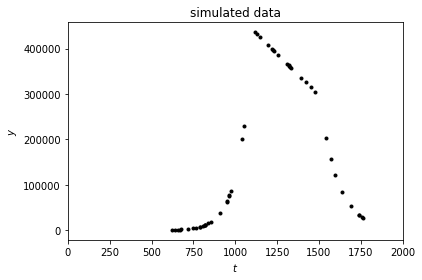

In [74]:
import numpy as np
from scipy.optimize import minimize
import celerite as ce
import matplotlib.pyplot as plt
from celerite import terms
from celerite.modeling import Model

#defining helper functions for model
def expf(t,a,b):
    return np.exp(a*(t-b))

def linef(t, x1, y1, x2, y2):
    m = (y2-y1)/(x2-x1)
    b = y2 - (m*x2)
    return ((m*t)+b)

#defining the model for our fit
class PWModel(Model):
    parameter_names = ("xl", "xr", "al", "bl", "ar", "br")
    
    def get_value(self, t):
        result = np.empty(len(t))
        for i in range(len(t)): #had to tweak this to accept t-arrays, may affect speed...
            if(t[i]<self.xl):
                result[i] = expf(t[i], self.al, self.bl)
            elif(self.xl<t[i] and t[i]<=self.xr):
                result[i] = linef(t[i], self.xl, expf(self.xl, self.al, self.bl), self.xr, expf(self.xr, self.ar, self.br))
            elif(self.xr<t[i]):
                result[i] = expf(t[i], self.ar, self.br)
        return result
    
    #the gradient terms were manually calculated
    def compute_gradient(self, t):
        yl = np.exp(self.al*(self.xl-self.bl))
        yr = np.exp(self.ar*(self.xr-self.br))
        result = np.empty([len(t), 6])
        result2 = np.empty([6, len(t)])
        for i in range(len(t)):
            ylt = np.exp(self.al*(t[i]-self.bl))
            yrt = np.exp(self.ar*(t[i]-self.br))
            if(t[i]<self.xl):
                dxl = 0.
                dxr = 0.
                dal = (t[i]-self.bl) * ylt
                dbl = -1* self.al * ylt
                dar = 0.
                dbr = 0.
                result[i] = np.array([dxl, dxr, dal, dbl, dar, dbr])
                result2[:,i] = result[i]

            elif(self.xl<=t[i] and t[i]<=self.xr):
                dxl = ((t[i]-self.xr)/((self.xr-self.xl)**2)) * (yr + (self.al * self.xl - self.al* self.xr +1) * yl)
                dxr = (((t[i]-self.xl)*(yl-yr) - self.ar*(self.xr-self.xl)*(self.xr-t[i])*yr)/((self.xl-self.xr)**2)) + self.ar * yr
                dal = -1.*((self.xl)/(self.xr-self.xl)) * yl
                dbl = ((self.al)/(self.xr-self.xl))*yl
                dar = ((1/(self.xr-self.xl))+1)*self.xr*yr
                dbr = -1.*((1/(self.xr-self.xl))+1) *self.ar*yr
                result[i] = np.array([dxl, dxr, dal, dbl, dar, dbr])
                result2[:,i] = result[i]
        

            elif(self.xr<t[i]):
                dxl = 0.
                dxr = 0.
                dal = 0.
                dar = (t[i]-self.br) * yrt
                dbl = 0.
                dbr = -1 * self.ar * yrt
                result[i] = np.array([dxl, dxr, dal, dbl, dar, dbr])
                result2[:,i] = result[i]

        return result2

#previously used paramter estimation
params0 = [1100, 1500, 1.3e-2, 100, -9e-3, 2900]
PW_Model = PWModel(xl = params0[0], xr = params0[1], al = params0[2], bl = params0[3], ar = params0[4], br = params0[5])
params_vec = PW_Model.get_parameter_vector()

# everything here is copied from the celerite documentation
# Simuate the data
np.random.seed(42)
x = np.sort(np.random.uniform(600, 1800, 50))
yerr = np.random.uniform(1, 100, len(x))
K = 0.1*np.exp(-0.5*(x[:, None] - x[None, :])**2/10.5)
K[np.diag_indices(len(x))] += yerr**2
y = np.random.multivariate_normal(PW_Model.get_value(x), K)

# Plot the data
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
plt.xlim(0, 2000)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
plt.title("simulated data")
plt.show()
        
data1 = "/Users/chris/Documents/QPP/SolarFlareGPs/data/121022782_ctime_lc.txt"
t1, I1 = np.loadtxt(data1, unpack=True)



Final log-likelihood: -637.6409237


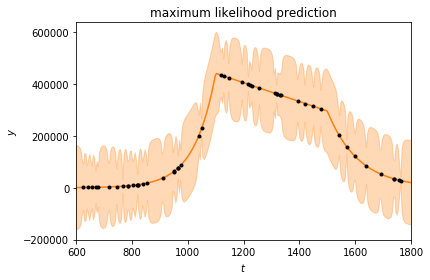

In [76]:
kernel = terms.RealTerm(log_a=np.log(np.var(y)), log_c =-np.log(10.))
gp = ce.GP(kernel, mean=PW_Model, fit_mean = True)
gp.compute(x, yerr)

# Define a cost function
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

# Fit for the maximum likelihood parameters
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(soln.x)
print("Final log-likelihood: {0}".format(-soln.fun))

# Make the maximum likelihood prediction
t = np.linspace(600, 2800, 500)
mu, var = gp.predict(y, t, return_var=True)
std = np.sqrt(var)

# Plot the data
color = "#ff7f0e"
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(t, mu, color=color)
plt.fill_between(t, mu+std, mu-std, color=color, alpha=0.3, edgecolor="none")
plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
plt.xlim(600, 1800)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
plt.title("maximum likelihood prediction")
plt.show()